In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from astropy.convolution import convolve
import scipy.stats
from tqdm import tqdm
from skimage.restoration import denoise_tv_bregman
from numpy.linalg import norm
import scipy
import bm3d

C:\Users\Drira Yosr\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Drira Yosr\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Drira Yosr\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def interpolate_nn(data: np.array) -> np.array:
    """
    Function to fill nan values in a 2D array using nearest neighbor
    interpolation.

    Source: https://stackoverflow.com/a/27745627
    """
    ind = nd.distance_transform_edt(np.isnan(data),
                                    return_distances=False,
                                    return_indices=True)
    return data[tuple(ind)]


# Ouverture des fichiers 


In [3]:
#filename_out = "S1B_IW_SLC__1SDV_20171223T014924_20171223T014951_008840_00FBF7_1A58_Orb_Stack(1).tif"
filename_out = "S1A_IW_SLC__1SDV_20170103T015004_20170103T015030_014661_017D92_6421_Orb_Stack(1).tif"
filename_out_bis = "S1A_IW_SLC__1SDV_20170103T015004_20170103T015030_014661_017D92_6421_Orb_Stack(2).tif"

image = tifffile.imread(filename_out)
image_bis = tifffile.imread(filename_out_bis)

image_1 = image[0,:,:] + 1j*image[1,:,:]

image_2 = image[2,:,:] + 1j*image[3,:,:]

image_3 = image_bis[2,:,:] + 1j*image_bis[3,:,:]

# Specification de la zone de pixels  

In [4]:
sy = np.s_[850:1100] 
sx = np.s_[15400:15900]
img1 = image_1[sy, sx]

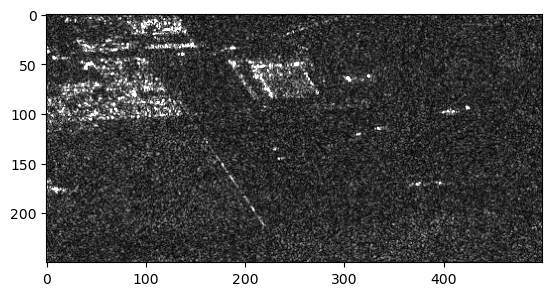

In [5]:
plt.imshow(np.abs(img1),cmap="gray",vmax= 1/5* np.max(np.abs(img1)))
plt.show()

In [6]:
img2 = image_2[sy, sx]

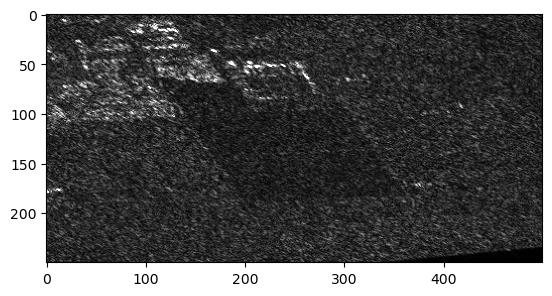

In [7]:
plt.imshow(np.abs(img2),cmap="gray",vmax= 1/5* np.max(np.abs(img2)))
plt.show()

In [8]:
img3 = image_3[sy, sx]

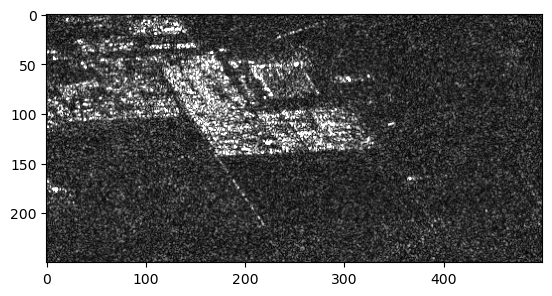

In [9]:
plt.imshow(np.abs(img3),cmap="gray",vmax= 1/5* np.max(np.abs(img3)))
plt.show()

# Forming the ratio image

In [10]:
reference_image = img1
def ratio(img, reference_img):
    # Ajoutez une petite valeur à reference_img pour éviter la division par zéro
    for i in range (np.shape(reference_img)[0]):
        for j in range (np.shape(reference_img)[1]):
             if reference_img[i, j] == 0.+0.j:
                    reference_img[i, j] = 1e-3+0.j               
    return np.clip(img / reference_image, 1e-3, 10)

ratio_img1 = ratio (img2, reference_image)
ratio_img2 = ratio (img3, reference_image) 


ratio_real1 = np.real(ratio_img1)
ratio_real2 = np.real(ratio_img2)

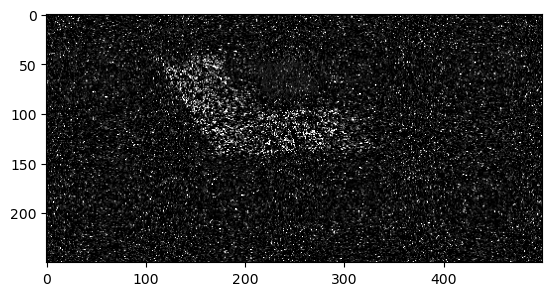

In [11]:
#affichage de l'image ratio: 
plt.imshow(np.abs(ratio_img2),cmap="gray",vmax= 1/10* np.max(np.abs(ratio_img2)))
plt.show()

# Image ratio réelle

In [12]:
#interpolation
ratio_nn1= list(map(interpolate_nn,tqdm(ratio_real1)))

100%|█████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 31337.26it/s]


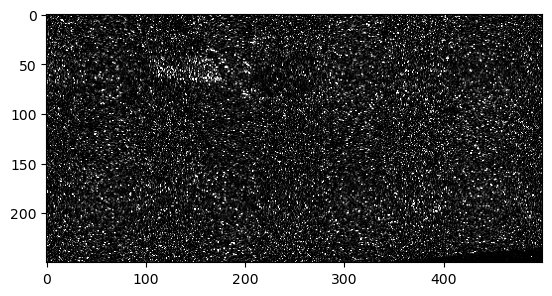

In [13]:
#affichage de l'image ratio réelle : 
plt.imshow(ratio_real1,cmap="gray",vmax= 1/2*np.max(ratio_real1))
plt.show()

In [14]:
#interpolation
ratio_nn2= list(map(interpolate_nn,tqdm(ratio_real2)))

100%|█████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 27853.58it/s]


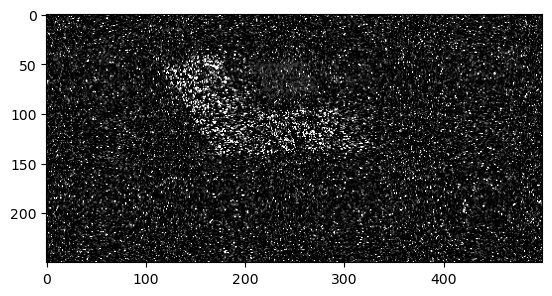

In [15]:
#affichage de l'image ratio réelle : 
plt.imshow(ratio_real2,cmap="gray",vmax= 1/2*np.max(ratio_real2))
plt.show()

# Denoising

In [16]:
from skimage import io, img_as_ubyte
from skimage.restoration import denoise_tv_bregman
import cv2

In [17]:
# Appliquer le débruitage avec le filtre TV-Bregman (débruitage anisotrope)
image_denoised1 = denoise_tv_bregman(ratio_real1, weight=0.1)
print("Taille de l'image : ",image_denoised1.shape)


Taille de l'image :  (250, 500)


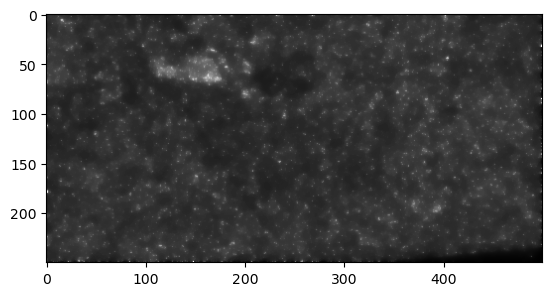

In [18]:
#affichage de l'image débruitée : 
plt.imshow(image_denoised1,cmap="gray",vmax= 1/2*np.max(image_denoised1))
plt.show()

In [19]:
# Appliquer le débruitage avec le filtre TV-Bregman (débruitage anisotrope)
image_denoised2 = denoise_tv_bregman(ratio_real2, weight=0.1)
print("Taille de l'image : ",image_denoised2.shape)

Taille de l'image :  (250, 500)


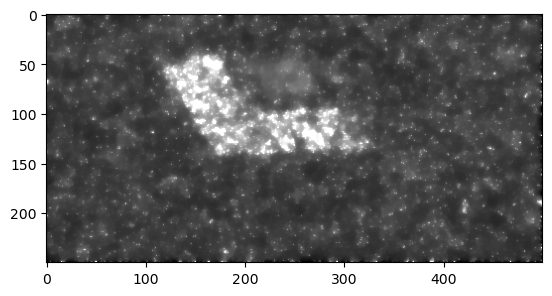

In [20]:
#affichage de l'image débruitée : 
plt.imshow(image_denoised2,cmap="gray",vmax= 1/2*np.max(image_denoised2))
plt.show()

# Seuillage

In [21]:
def seuillage(image_gris, seuil):
    _, image_bw = cv2.threshold(image_gris, seuil, 255, cv2.THRESH_BINARY)
    return image_bw

# Charger l'image en niveaux de gris
image_gris1 = image_denoised1
image_gris2 = image_denoised2

# Spécifier le seuil (ajustez cette valeur en fonction de vos besoins)
seuil =1

# Appliquer le seuillage
image_bw1 = seuillage(image_gris1, seuil)
image_bw2 = seuillage(image_gris2, seuil)

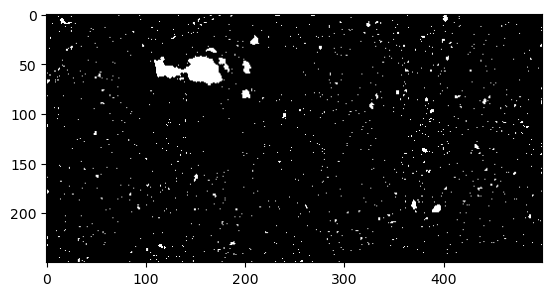

In [22]:
#affichage de l'image en noir et blanc: 
plt.imshow(image_bw1,cmap="gray",vmax= 1* np.max(image_bw1))
plt.show()

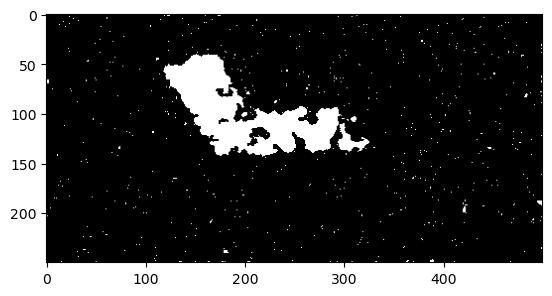

In [23]:
#affichage de l'image en noir et blanc: 
plt.imshow(image_bw2,cmap="gray",vmax= 1* np.max(image_bw2))
plt.show()

# Zoom sur la zone d'intérêt 

In [24]:
sx2 = np.s_[100:350] 
sy2 = np.s_[30:150]
imgbw1 = image_bw1[sy2, sx2]
imgbw2 = image_bw2[sy2, sx2]

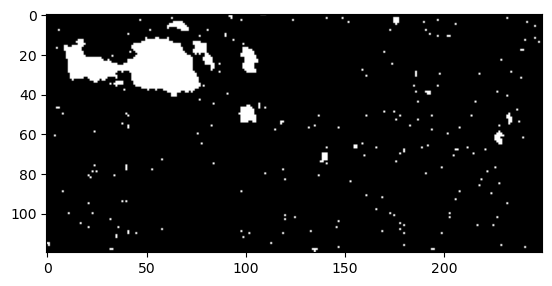

In [25]:
plt.imshow(imgbw1,cmap="gray",vmax= 1* np.max(imgbw1))
plt.show()

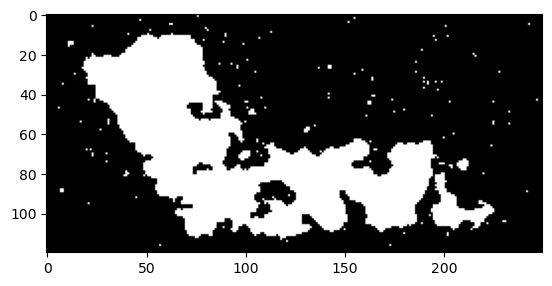

In [26]:
plt.imshow(imgbw2,cmap="gray",vmax= 1* np.max(imgbw2))
plt.show()

# Surface de la zone blanche

Type de l'image : float32
Type de l'image : uint8
Surface de la zone blanche : 1639 pixels carrés


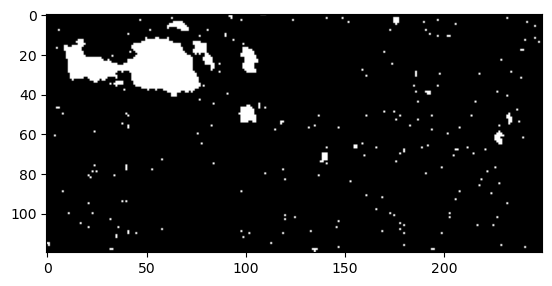

In [27]:
import cv2

print("Type de l'image : {}".format(imgbw1.dtype))

# Charger l'image en noir et blanc
#image = cv2.imread(ratio_img, cv2.IMREAD_GRAYSCALE)

image_float32 = np.random.rand(256, 256).astype(np.float32)

image_scaled = (imgbw1 * 255).clip(0, 255).astype(np.uint8)

# Afficher le type résultant
print("Type de l'image : {}".format(image_scaled.dtype))

plt.imshow(image_scaled,cmap="gray")


# Binariser l'image (convertir en noir et blanc)
_, binary_image = cv2.threshold(image_scaled, 128, 255, cv2.THRESH_BINARY)

# Compter le nombre de pixels blancs dans l'image
white_pixel_count = np.sum(binary_image == 255)

# Afficher la surface de la zone blanche en pixels carrés
print("Surface de la zone blanche : {} pixels carrés".format(white_pixel_count))

Type de l'image : float32
Type de l'image : uint8
Surface de la zone blanche : 8243 pixels carrés


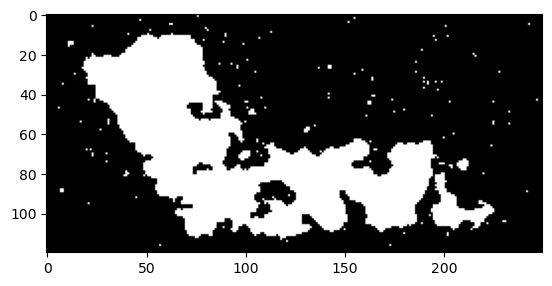

In [28]:
print("Type de l'image : {}".format(imgbw2.dtype))

# Charger l'image en noir et blanc
#image = cv2.imread(ratio_img, cv2.IMREAD_GRAYSCALE)

image_float32 = np.random.rand(256, 256).astype(np.float32)

image_scaled = (imgbw2 * 255).clip(0, 255).astype(np.uint8)

# Afficher le type résultant
print("Type de l'image : {}".format(image_scaled.dtype))

plt.imshow(image_scaled,cmap="gray")


# Binariser l'image (convertir en noir et blanc)
_, binary_image = cv2.threshold(image_scaled, 128, 255, cv2.THRESH_BINARY)

# Compter le nombre de pixels blancs dans l'image
white_pixel_count = np.sum(binary_image == 255)

# Afficher la surface de la zone blanche en pixels carrés
print("Surface de la zone blanche : {} pixels carrés".format(white_pixel_count))

# Enlever les pixels blancs hors de la zone d'intérêt: